In [2]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import datetime

This notebook (script) is where the geolocation of the events is merged with the event information from EM-DAT.
In addition, many information needed to the aggregation of the climate data will be added, namely:
- Exact start and end of events
- Start and end of climate variable aggregation (1 year before and 1 year after event start)

    - for the events with missing dates, if the month is missing, the record is removed from the data as there is no way of gap-filling that information.
    - if only the day is missing, that information is gap-filled in an arbitrary but consistent way: the start of the event is assigned to be the beginning of the month. Then, the median duration of each type of events is calculated, and used to determine an end date (day of the month). Except for very long events in time (droughts), this method can be inefficient for very short events (e.g. storms), this is why another filtering method after the aggregation with the climate variables is not excluded to verify if the date gap-filling worked.

- Geometries without an ISO code are excluded from the database.

The data merger will be done as a first step on the individual geometries of each event as geolocated so far, but considering that the reported impact are at the national level, the event geometries of every country will be overlayed together.

In [2]:
geolocations = gpd.read_file('/net/home/kteber/xaida_p1/data/gaul/geolocated_events_gaul_gdis.gpkg')

In [3]:
geolocations = geolocations.set_index('Dis No')

In [4]:
#read data & select events between 1990 and 2020
emdat = pd.read_excel('/net/home/kteber/xaida_dataset/data/emdat/emdat_public_1960_2022.xlsx')
emdat = emdat.set_index('Dis No')

emdat_90_20 = emdat[(emdat.Year > 1989) & (emdat.Year < 2021)]

## 1 - Merge without Overlay

In [5]:
geolocations_emdat_merged = pd.merge(geolocations, emdat_90_20, on="Dis No",how="left")

In [6]:
geolocations_emdat_merged['Disno'] = geolocations_emdat_merged.index

In [7]:
geolocations_emdat_merged["Occ_Number"] = (geolocations_emdat_merged.groupby("Dis No").cumcount()+1).astype(str)

In [8]:
geolocations_emdat_merged['Event-poly-id'] = geolocations_emdat_merged[['Disno','Occ_Number']].agg('-'.join, axis=1)

In [9]:
geolocations_emdat_merged['disasterno'] = geolocations_emdat_merged.disaster_number_country.str.split('-',expand=True)[[0,1]].agg('-'.join, axis=1)

In [10]:
geolocations_emdat_merged.columns

Index(['iso3', 'official_name', 'ADM0_CODE', 'ADM0_NAME', 'ADM1_CODE',
       'ADM1_NAME', 'location', 'geolocation', 'ADM2_CODE', 'ADM2_NAME',
       'level', 'disaster_number_country', 'geo', 'geometry', 'Year', 'Seq',
       'Glide', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'Country',
       'ISO', 'Region', 'Continent', 'Location', 'Origin', 'Associated Dis',
       'Associated Dis2', 'OFDA Response', 'Appeal', 'Declaration',
       'Aid Contribution', 'Dis Mag Value', 'Dis Mag Scale', 'Latitude',
       'Longitude', 'Local Time', 'River Basin', 'Start Year', 'Start Month',
       'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths',
       'No Injured', 'No Affected', 'No Homeless', 'Total Affected',
       'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damages ('000 US$)', 'Insured Damages, Adjusted ('000 US$)',
       'Total Damages ('

In [11]:
disasters_by_event = geolocations_emdat_merged.loc[:,['disasterno','Disno','Event-poly-id','geometry','ADM0_NAME','official_name','iso3',
                                                      'ADM1_CODE','ADM1_NAME','ADM2_CODE','ADM2_NAME','level',
                                              'Disaster Group','Disaster Subgroup','Disaster Type', 'Disaster Subtype','Disaster Subsubtype',
                                              'Associated Dis','Associated Dis2','Event Name','Region', 'Continent','River Basin','Location',
                                              'geolocation', 'OFDA Response', 'Appeal', 'Declaration','Aid Contribution', 'Dis Mag Value',
                                              'Dis Mag Scale','Local Time',
                                              'Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected',
                                              'Total Damages (\'000 US$)','Total Damages, Adjusted (\'000 US$)',
                                              'Insured Damages (\'000 US$)','Insured Damages, Adjusted (\'000 US$)',
                                               'Year','Start Year', 'Start Month',
                                              'Start Day', 'End Year', 'End Month','End Day','geo']]

In [12]:
disasters_by_event = disasters_by_event.sort_values('Disno')

In [13]:
disasters_by_event = disasters_by_event.rename(columns={'disasterno':'disaster_number','Disno':'disaster_number_country','Event-poly-id':'event_poly_id','iso3':'iso',
                                   'ADM0_NAME':'country','ADM1_CODE':'adm1_code','ADM1_NAME':'adm1_name','ADM2_CODE':'adm2_code','ADM2_NAME':'adm2_name',
                                   'Disaster Group': 'disaster_group',
                                   'Disaster Subgroup':'disaster_subgroup','Disaster Type':'disaster_type',
                                   'Disaster Subtype':'disaster_subtype','Disaster Subsubtype':'disaster_subsubtype','Associated Dis':'associated_disaster',
                                   'Associated Dis2':'associated_disaster2','Event Name':'event_name',
                                   'Region':'region', 'Continent':'continent','River Basin':'river_basin','Location':'location',
                                   'OFDA Response':'ofda_response', 'Appeal':'appeal', 'Declaration':'declaration','Aid Contribution':'aid_contribution',
                                   'Dis Mag Value':'magnitude_value','Dis Mag Scale':'magnitude_scale','Local Time':'local_time',
                                   'Total Deaths':'total_deaths', 'No Injured':'number_injured', 'No Affected':'number_affected',
                                   'No Homeless':'number_homeless', 'Total Affected':'total_affected',
                                   'Total Damages (\'000 US$)':'total_damages', 'Total Damages, Adjusted (\'000 US$)':'total_damages_adjusted',
                                   'Insured Damages (\'000 US$)':'insured_damages','Insured Damages, Adjusted (\'000 US$)':'insured_damages_adjusted',
                                   'Year':'year', 'level':'administrative_level','geo':'geo_source'})

In [14]:
disasters_by_event.shape

(49597, 49)

In [15]:
#remove non natural (technological disaster entries
disasters_by_event = disasters_by_event[~(disasters_by_event['disaster_group'] == 'Technological')]

In [16]:
#remove Biological disaster entries
disasters_by_event = disasters_by_event[~(disasters_by_event['disaster_subgroup'] == 'Biological')]

In [17]:
colnames = disasters_by_event.dtypes[disasters_by_event.dtypes == 'object']

In [18]:
colnames

disaster_number            object
disaster_number_country    object
event_poly_id              object
country                    object
official_name              object
iso                        object
adm1_code                  object
adm1_name                  object
adm2_code                  object
adm2_name                  object
administrative_level       object
disaster_group             object
disaster_subgroup          object
disaster_type              object
disaster_subtype           object
disaster_subsubtype        object
associated_disaster        object
associated_disaster2       object
event_name                 object
region                     object
continent                  object
river_basin                object
location                   object
geolocation                object
ofda_response              object
appeal                     object
declaration                object
magnitude_scale            object
local_time                 object
geo_source    

In [19]:
for col in colnames.index:
    print(col)
    disasters_by_event[col] = disasters_by_event[col].str.lstrip()
    disasters_by_event[col] = disasters_by_event[col].str.rstrip()

disaster_number
disaster_number_country
event_poly_id
country
official_name
iso
adm1_code
adm1_name
adm2_code
adm2_name
administrative_level
disaster_group
disaster_subgroup
disaster_type
disaster_subtype
disaster_subsubtype
associated_disaster
associated_disaster2
event_name
region
continent
river_basin
location
geolocation
ofda_response
appeal
declaration
magnitude_scale
local_time
geo_source


In [20]:
disasters_by_event.shape

(44560, 49)

In [21]:
np.round(disasters_by_event.isnull().sum() / 44560 * 100)

disaster_number              0.0
disaster_number_country      0.0
event_poly_id                0.0
geometry                     0.0
country                      0.0
official_name                0.0
iso                          0.0
adm1_code                    0.0
adm1_name                    0.0
adm2_code                    0.0
adm2_name                    3.0
administrative_level         0.0
disaster_group               1.0
disaster_subgroup            1.0
disaster_type                1.0
disaster_subtype            13.0
disaster_subsubtype         89.0
associated_disaster         63.0
associated_disaster2        90.0
event_name                  82.0
region                       1.0
continent                    1.0
river_basin                 85.0
location                     1.0
geolocation                  1.0
ofda_response               88.0
appeal                      91.0
declaration                 80.0
aid_contribution            91.0
magnitude_value             60.0
magnitude_

In [22]:
disasters_by_event = disasters_by_event[~(disasters_by_event['Start Year'].isna())]
disasters_by_event = disasters_by_event[~(disasters_by_event['Start Month'].isna())]
disasters_by_event = disasters_by_event[~(disasters_by_event['End Month'].isna())]
disasters_by_event = disasters_by_event[~(disasters_by_event['Start Month'].isna())]

In [23]:
disasters_by_event.shape

(42945, 49)

In [24]:
np.round(disasters_by_event.isnull().sum() / 42945 * 100)

disaster_number              0.0
disaster_number_country      0.0
event_poly_id                0.0
geometry                     0.0
country                      0.0
official_name                0.0
iso                          0.0
adm1_code                    0.0
adm1_name                    0.0
adm2_code                    0.0
adm2_name                    2.0
administrative_level         0.0
disaster_group               0.0
disaster_subgroup            0.0
disaster_type                0.0
disaster_subtype            13.0
disaster_subsubtype         89.0
associated_disaster         63.0
associated_disaster2        90.0
event_name                  81.0
region                       0.0
continent                    0.0
river_basin                 84.0
location                     1.0
geolocation                  1.0
ofda_response               88.0
appeal                      91.0
declaration                 81.0
aid_contribution            91.0
magnitude_value             59.0
magnitude_

### Calculate disaster durations manually

In [25]:
disaster_dates = disasters_by_event.loc[:,['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month','End Day']]

In [26]:
# creating a pandas dataframe 
df_start_date = pd.DataFrame({"year": disaster_dates["Start Year"],"month": disaster_dates["Start Month"],"day": [x if np.isfinite(x) else 1 for x in disaster_dates["Start Day"]]}) 

In [27]:
df_start_date.loc[(df_start_date['month'] == 9) & (df_start_date['day'] == 31),'day'] = 30

In [28]:
df_start_date[df_start_date.year ==  30]

,year,month,day
Dis No,,,


In [29]:
np.unique(df_start_date.year)

array([1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017., 2018., 2019., 2020., 2021.])

In [30]:
# converting the float to datetime format
df_start_date['Date'] = pd.to_datetime(df_start_date,format='%Y%m%d')

In [31]:
# creating a pandas dataframe 
df_end_date = pd.DataFrame({"year": disaster_dates["End Year"],"month": disaster_dates["End Month"],"day": disaster_dates["End Day"]})

In [32]:
test_date = df_end_date.groupby(['month','day']).count()
test_date = test_date.reset_index()
test_date[test_date.month == 6]

,month,day,year
152,6.0,1.0,129
153,6.0,2.0,165
154,6.0,3.0,63
155,6.0,4.0,45
156,6.0,5.0,103
157,6.0,6.0,115
158,6.0,7.0,79
159,6.0,8.0,88
160,6.0,9.0,48
161,6.0,10.0,137


In [33]:
df_end_date.loc[(df_end_date['month'] == 9) & (df_end_date['day'] == 31),'day'] = 30
df_end_date.loc[(df_end_date['month'] == 6) & (df_end_date['day'] == 31),'day'] = 30

In [34]:
# converting the float to datetime format
df_end_date['Date'] = pd.to_datetime(df_end_date, format='%Y%m%d')

In [35]:
event_duration = df_end_date['Date'] - df_start_date['Date']

In [36]:
event_duration = event_duration + datetime.timedelta(1)

In [37]:
event_duration

Dis No
1990-0001-LKA   9 days
1990-0001-LKA   9 days
1990-0001-LKA   9 days
1990-0001-LKA   9 days
1990-0001-LKA   9 days
                 ...  
2020-9585-USA      NaT
2020-9585-USA      NaT
2020-9585-USA      NaT
2020-9585-USA      NaT
2020-9585-USA      NaT
Name: Date, Length: 42945, dtype: timedelta64[ns]

In [38]:
disasters_by_event['start_date'] = df_start_date['Date']
disasters_by_event['end_date'] = df_end_date['Date']
disasters_by_event['event_duration'] = event_duration

In [39]:
disasters_by_event_with_full_dates = disasters_by_event[~np.isnat(disasters_by_event.end_date)]

In [40]:
disasters_by_event_with_full_dates['duration_source'] = 'emdat'

/net/home/kteber/.conda/envs/xtreme3/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [41]:
disasters_by_event_with_full_dates

,disaster_number,disaster_number_country,event_poly_id,geometry,country,official_name,iso,adm1_code,adm1_name,adm2_code,...,Start Month,Start Day,End Year,End Month,End Day,geo_source,start_date,end_date,event_duration,duration_source
Dis No,,,,,,,,,,,,,,,,,,,,,
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-1,"POLYGON ((80.49657 7.80912, 80.49657 7.80952, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,25830,...,1.0,6.0,1990.0,1.0,14.0,GAUL,1990-01-06,1990-01-14,9 days,emdat
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-2,"POLYGON ((80.46715 7.02203, 80.46714 7.02214, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,41749,...,1.0,6.0,1990.0,1.0,14.0,GAUL,1990-01-06,1990-01-14,9 days,emdat
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-3,"POLYGON ((80.56631 7.45748, 80.56660 7.45725, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,41748,...,1.0,6.0,1990.0,1.0,14.0,GAUL,1990-01-06,1990-01-14,9 days,emdat
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-4,"POLYGON ((80.97974 7.62435, 80.97975 7.62445, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2737,Eastern,25832,...,1.0,6.0,1990.0,1.0,14.0,GAUL,1990-01-06,1990-01-14,9 days,emdat
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-5,"POLYGON ((80.49657 7.80912, 80.49659 7.80868, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2739,North Western,25837,...,1.0,6.0,1990.0,1.0,14.0,GAUL,1990-01-06,1990-01-14,9 days,emdat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-0602-MNG,2020-0602,2020-0602-MNG,2020-0602-MNG-4,"POLYGON ((108.40219 47.48946, 108.40222 47.489...",Mongolia,Mongolia,MNG,2086,Xentii,None,...,7.0,8.0,2020.0,8.0,15.0,GAUL,2020-07-08,2020-08-15,39 days,emdat
2020-0602-MNG,2020-0602,2020-0602-MNG,2020-0602-MNG-5,"POLYGON ((99.42603 44.11837, 99.48341 44.12429...",Mongolia,Mongolia,MNG,2089,O'mnogovi,None,...,7.0,8.0,2020.0,8.0,15.0,GAUL,2020-07-08,2020-08-15,39 days,emdat
2020-0602-MNG,2020-0602,2020-0602-MNG,2020-0602-MNG-3,"POLYGON ((103.95506 48.99564, 103.98029 49.023...",Mongolia,Mongolia,MNG,2090,Orxon,None,...,7.0,8.0,2020.0,8.0,15.0,GAUL,2020-07-08,2020-08-15,39 days,emdat


In [42]:
disasters_by_event_with_full_dates.loc[:,['disaster_type','event_duration']].groupby('disaster_type').agg(['min','mean','median','max','count']).round()

event_duration                                       \
                               min                        mean   median   
disaster_type                                                             
Drought                    92 days 149 days 04:29:16.097560976 132 days   
Earthquake                  1 days   1 days 00:37:16.893203883   1 days   
Extreme temperature         1 days  20 days 04:44:26.116554925  11 days   
Flood                       1 days  18 days 03:15:04.063911080   8 days   
Landslide                   1 days   4 days 06:09:39.696616102   1 days   
Mass movement (dry)         1 days  10 days 13:09:40.645161290   1 days   
Storm                       1 days   4 days 02:01:14.521030610   2 days   
Volcanic activity           1 days   8 days 22:16:47.508532423   1 days   
Wildfire                    1 days  25 days 10:03:29.708737864   7 days   

                                     
                         max  count  
disaster_type                        
Drought             306 days    123  
Earthquake           10 days   1854  
Extreme temperature 377 days   1939  
Flood               336 days  17274  
Landslide            89 days    857  
Mass movement (dry)  38 days     31  
Storm               370 days  13623  
Volcanic activity   254 days    293  
Wildfire            214 days    618

In [43]:
disasters_by_event_without_dates_samey = disasters_by_event[(np.isnat(disasters_by_event.end_date)) & (disasters_by_event['Start Year'] == disasters_by_event['End Year'])]

In [44]:
disasters_by_event_without_dates_samey.shape

(5237, 52)

In [45]:
disasters_by_event_without_dates_diffy = disasters_by_event[(np.isnat(disasters_by_event.end_date)) & (disasters_by_event['Start Year'] != disasters_by_event['End Year'])]

In [46]:
disasters_by_event_without_dates_diffy.shape

(1096, 52)

In [47]:
def fill_duration_gaps(disaster_type):
    event_duration = None
    if disaster_type=='Drought':
        event_duration = datetime.timedelta(132)
    elif disaster_type=='Earthquake' or disaster_type=='Landslide' or disaster_type=='Mass movement (dry)' or disaster_type=='Volcanic activity':
        event_duration = datetime.timedelta(1)
    elif disaster_type=='Extreme temperature':
        event_duration = datetime.timedelta(11)
    elif disaster_type=='Flood':
        event_duration = datetime.timedelta(8)
    elif disaster_type=='Storm':
        event_duration = datetime.timedelta(3)
    elif disaster_type=='Wildfire':
        event_duration = datetime.timedelta(6)
    else:
        myvalue=np.nan
    return event_duration

In [48]:
disasters_by_event_without_dates_samey['event_duration'] = disasters_by_event_without_dates_samey.apply(lambda x: fill_duration_gaps(x['disaster_type']), axis=1)

/net/home/kteber/.conda/envs/xtreme3/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
disasters_by_event_without_dates_samey['end_date'] = disasters_by_event_without_dates_samey['start_date'] + disasters_by_event_without_dates_samey['event_duration']

In [50]:
disasters_by_event_without_dates_samey['duration_source'] = 'gap-filled'

/net/home/kteber/.conda/envs/xtreme3/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [51]:
disasters_by_event_without_dates_diffy['End Day'] = 1

In [52]:
# creating a pandas dataframe 
df_end_date_diffy = pd.DataFrame({"year": disasters_by_event_without_dates_diffy["End Year"],"month": disasters_by_event_without_dates_diffy["End Month"],"day": disasters_by_event_without_dates_diffy["End Day"]}) 

In [53]:
# converting the float to datetime format
df_end_date_diffy['Date'] = pd.to_datetime(df_end_date_diffy, format='%Y%m%d')

In [54]:
# converting the float to datetime format
disasters_by_event_without_dates_diffy['end_date'] = df_end_date_diffy['Date']

/net/home/kteber/.conda/envs/xtreme3/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [55]:
disasters_by_event_without_dates_diffy['event_duration'] = disasters_by_event_without_dates_diffy['end_date'] - disasters_by_event_without_dates_diffy['start_date']

In [56]:
disasters_by_event_without_dates_diffy['duration_source'] = 'gap-filled'

/net/home/kteber/.conda/envs/xtreme3/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [57]:
disasters_by_event_full_dates = pd.concat([disasters_by_event_with_full_dates,disasters_by_event_without_dates_samey, disasters_by_event_without_dates_diffy], axis=0)

In [58]:
disasters_by_event_full_dates.shape

(42945, 53)

In [59]:
np.round(disasters_by_event_full_dates.isnull().sum() / 42945 * 100)

disaster_number              0.0
disaster_number_country      0.0
event_poly_id                0.0
geometry                     0.0
country                      0.0
official_name                0.0
iso                          0.0
adm1_code                    0.0
adm1_name                    0.0
adm2_code                    0.0
adm2_name                    2.0
administrative_level         0.0
disaster_group               0.0
disaster_subgroup            0.0
disaster_type                0.0
disaster_subtype            13.0
disaster_subsubtype         89.0
associated_disaster         63.0
associated_disaster2        90.0
event_name                  81.0
region                       0.0
continent                    0.0
river_basin                 84.0
location                     1.0
geolocation                  1.0
ofda_response               88.0
appeal                      91.0
declaration                 81.0
aid_contribution            91.0
magnitude_value             59.0
magnitude_

In [60]:
disasters_by_event_full_dates.loc[:,['disaster_type','event_duration']].groupby('disaster_type').agg(['min','mean','median','max','count']).round()

event_duration                                       \
                               min                        mean   median   
disaster_type                                                             
Complex Disasters              NaT                         NaT      NaT   
Drought                    62 days 243 days 13:34:00.485829960 132 days   
Earthquake                  1 days   1 days 00:37:16.893203883   1 days   
Extreme temperature         1 days  18 days 02:29:47.699316628  11 days   
Flood                       1 days  18 days 00:44:30.329670329   8 days   
Landslide                   1 days   4 days 03:51:34.450736126   1 days   
Mass movement (dry)         1 days  10 days 13:09:40.645161290   1 days   
Storm                       1 days   4 days 03:45:04.806665242   3 days   
Volcanic activity           1 days   9 days 13:54:10.485436893   1 days   
Wildfire                    1 days  19 days 04:05:42.502585315   6 days   

                                      
                          max  count  
disaster_type                         
Complex Disasters         NaT      0  
Drought             1461 days   1976  
Earthquake            10 days   1854  
Extreme temperature  377 days   3951  
Flood                336 days  18928  
Landslide             89 days    883  
Mass movement (dry)   38 days     31  
Storm                370 days  14043  
Volcanic activity    254 days    309  
Wildfire             214 days    967

In [61]:
disasters_by_event_full_dates[disasters_by_event_full_dates.disaster_type == 'Complex Disasters']

,disaster_number,disaster_number_country,event_poly_id,geometry,country,official_name,iso,adm1_code,adm1_name,adm2_code,...,Start Month,Start Day,End Year,End Month,End Day,geo_source,start_date,end_date,event_duration,duration_source
Dis No,,,,,,,,,,,,,,,,,,,,,
2007-9070-BDI,2007-9070,2007-9070-BDI,2007-9070-BDI-1,"POLYGON ((29.43043 -2.80456, 29.43083 -2.80442...",Burundi,Republic of Burundi,BDI,40550,Kayanza,None,...,2.0,NaN,2007.0,2.0,NaN,GAUL,2007-02-01,NaT,NaT,gap-filled
2012-9159-YEM,2012-9159,2012-9159-YEM,2012-9159-YEM-1,"POLYGON ((43.50607 15.04960, 43.50817 15.05716...",Yemen,Republic of Yemen,YEM,144972,Sana'a,None,...,6.0,NaN,2012.0,6.0,NaN,GAUL,2012-06-01,NaT,NaT,gap-filled
2012-9159-YEM,2012-9159,2012-9159-YEM,2012-9159-YEM-2,"MULTIPOLYGON (((42.27892 16.14698, 42.28098 16...",Yemen,Republic of Yemen,YEM,3418,Hajjah,None,...,6.0,NaN,2012.0,6.0,NaN,GAUL,2012-06-01,NaT,NaT,gap-filled


In [62]:
disasters_by_event_full_dates = disasters_by_event_full_dates.drop(['2007-9070-BDI','2012-9159-YEM'])

In [63]:
disasters_by_event_full_dates['event_duration'] = disasters_by_event_full_dates.event_duration.apply(lambda x : x.days)

In [64]:
disasters_by_event_full_dates = disasters_by_event_full_dates.drop(columns=['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month','End Day'])

In [65]:
disasters_by_event_full_dates.groupby(['duration_source','disaster_type']).count()

disaster_number  disaster_number_country  \
duration_source disaster_type                                                   
emdat           Drought                          123                      123   
                Earthquake                      1854                     1854   
                Extreme temperature             1939                     1939   
                Flood                          17274                    17274   
                Landslide                        857                      857   
                Mass movement (dry)               31                       31   
                Storm                          13623                    13623   
                Volcanic activity                293                      293   
                Wildfire                         618                      618   
gap-filled      Drought                         1853                     1853   
                Extreme temperature             2012                     2012   
                Flood                           1654                     1654   
                Landslide                         26                       26   
                Storm                            420                      420   
                Volcanic activity                 16                       16   
                Wildfire                         349                      349   

                                     event_poly_id  geometry  country  \
duration_source disaster_type                                           
emdat           Drought                        123       123      123   
                Earthquake                    1854      1854     1854   
                Extreme temperature           1939      1939     1939   
                Flood                        17274     17274    17274   
                Landslide                      857       857      857   
                Mass movement (dry)             31        31       31   
                Storm                        13623     13623    13623   
                Volcanic activity              293       293      293   
                Wildfire                       618       618      618   
gap-filled      Drought                       1853      1853     1853   
                Extreme temperature           2012      2012     2012   
                Flood                         1654      1654     1654   
                Landslide                       26        26       26   
                Storm                          420       420      420   
                Volcanic activity               16        16       16   
                Wildfire                       349       349      349   

                                     official_name    iso  adm1_code  \
duration_source disaster_type                                          
emdat           Drought                        123    123        123   
                Earthquake                    1854   1854       1854   
                Extreme temperature           1939   1939       1939   
                Flood                        17274  17274      17274   
                Landslide                      857    857        857   
                Mass movement (dry)             31     31         31   
                Storm                        13622  13622      13623   
                Volcanic activity              293    293        293   
                Wildfire                       618    618        618   
gap-filled      Drought                       1853   1853       1853   
                Extreme temperature           2012   2012       2012   
                Flood                         1654   1654       1654   
                Landslide                       26     26         26   
                Storm                          420    420        420   
                Volcanic activity               16     16         16   
                Wildfire               

In [66]:
disasters_by_event_full_dates['start_aggregation'] = pd.to_datetime(disasters_by_event_full_dates['start_date']) - datetime.timedelta(days = 1095)

In [67]:
disasters_by_event_full_dates['end_aggregation'] = pd.to_datetime(disasters_by_event_full_dates['start_date']) + datetime.timedelta(days = 1095)

In [68]:
disasters_by_event_full_dates['start_day'] = [x for x in (disasters_by_event_full_dates.start_date - disasters_by_event_full_dates.start_date).dt.days]

In [69]:
disasters_by_event_full_dates['end_day'] = [x if x != 0 else 1 for x in (disasters_by_event_full_dates.end_date - disasters_by_event_full_dates.start_date).dt.days]

In [70]:
disasters_by_event_full_dates

,disaster_number,disaster_number_country,event_poly_id,geometry,country,official_name,iso,adm1_code,adm1_name,adm2_code,...,year,geo_source,start_date,end_date,event_duration,duration_source,start_aggregation,end_aggregation,start_day,end_day
Dis No,,,,,,,,,,,,,,,,,,,,,
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-1,"POLYGON ((80.49657 7.80912, 80.49657 7.80952, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,25830,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-2,"POLYGON ((80.46715 7.02203, 80.46714 7.02214, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,41749,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-3,"POLYGON ((80.56631 7.45748, 80.56660 7.45725, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,41748,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-4,"POLYGON ((80.97974 7.62435, 80.97975 7.62445, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2737,Eastern,25832,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-5,"POLYGON ((80.49657 7.80912, 80.49659 7.80868, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2739,North Western,25837,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-9424-MDG,2020-9424,2020-9424-MDG,2020-9424-MDG-2,"MULTIPOLYGON (((44.21448 -25.22500, 44.21561 -...",Madagascar,Republic of Madagascar,MDG,41756,Atsimo Andrefana,154538,...,2020.0,GAUL,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882
2020-9424-MDG,2020-9424,2020-9424-MDG,2020-9424-MDG-1,"MULTIPOLYGON (((43.65321 -23.76676, 43.65320 -...",Madagascar,Republic of Madagascar,MDG,41756,Atsimo Andrefana,154546,...,2020.0,GAUL,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882
2020-9424-MDG,2020-9424,2020-9424-MDG,2020-9424-MDG-3,"POLYGON ((45.08257 -23.88944, 45.08250 -23.891...",Madagascar,Republic of Madagascar,MDG,41756,Atsimo Andrefana,154542,...,2020.0,GAUL,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882


In [71]:
disasters_by_event_full_dates = disasters_by_event_full_dates.drop(['2020-0051-IRL']) #event starts in 2021 not in 2020!

In [72]:
disasters_by_event_full_dates[['start_aggregation','end_aggregation']] = disasters_by_event_full_dates[['start_aggregation','end_aggregation']].astype(str)

In [73]:
disasters_by_event_full_dates

,disaster_number,disaster_number_country,event_poly_id,geometry,country,official_name,iso,adm1_code,adm1_name,adm2_code,...,year,geo_source,start_date,end_date,event_duration,duration_source,start_aggregation,end_aggregation,start_day,end_day
Dis No,,,,,,,,,,,,,,,,,,,,,
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-1,"POLYGON ((80.49657 7.80912, 80.49657 7.80952, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,25830,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-2,"POLYGON ((80.46715 7.02203, 80.46714 7.02214, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,41749,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-3,"POLYGON ((80.56631 7.45748, 80.56660 7.45725, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736,Central,41748,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-4,"POLYGON ((80.97974 7.62435, 80.97975 7.62445, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2737,Eastern,25832,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
1990-0001-LKA,1990-0001,1990-0001-LKA,1990-0001-LKA-5,"POLYGON ((80.49657 7.80912, 80.49659 7.80868, ...",Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2739,North Western,25837,...,1990.0,GAUL,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-9424-MDG,2020-9424,2020-9424-MDG,2020-9424-MDG-2,"MULTIPOLYGON (((44.21448 -25.22500, 44.21561 -...",Madagascar,Republic of Madagascar,MDG,41756,Atsimo Andrefana,154538,...,2020.0,GAUL,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882
2020-9424-MDG,2020-9424,2020-9424-MDG,2020-9424-MDG-1,"MULTIPOLYGON (((43.65321 -23.76676, 43.65320 -...",Madagascar,Republic of Madagascar,MDG,41756,Atsimo Andrefana,154546,...,2020.0,GAUL,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882
2020-9424-MDG,2020-9424,2020-9424-MDG,2020-9424-MDG-3,"POLYGON ((45.08257 -23.88944, 45.08250 -23.891...",Madagascar,Republic of Madagascar,MDG,41756,Atsimo Andrefana,154542,...,2020.0,GAUL,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882


In [75]:
disasters_by_event_full_dates.to_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_regional_no_overlay.gpkg", driver="GPKG")

In [74]:
len(np.unique(disasters_by_event_full_dates.index))

9397

## 2 - Merge with country Overlay

In [12]:
disasters_by_event_full_dates = gpd.read_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_regional_no_overlay.gpkg")

In [13]:
disasters_by_event_full_dates = disasters_by_event_full_dates.set_index('Dis No')

In [75]:
disasters_national_overlay = disasters_by_event_full_dates.dissolve(by=['Dis No'],aggfunc={
    'disaster_number': lambda x: np.unique(x)[0],
    'disaster_number_country': lambda x: np.unique(x)[0],
    'event_poly_id' : 'count',
    'country': lambda x: np.unique((x).astype(str))[0],
    'official_name': lambda x: np.unique((x).astype(str))[0],
    'iso': lambda x: np.unique((x).astype(str))[0],
    'adm1_code': lambda x : ' - '.join(np.unique((x).astype(str))),
    'adm1_name': lambda x : ' - '.join(np.unique((x).astype(str))),
    'adm2_code': lambda x : ' - '.join(np.unique((x).astype(str))),
    'adm2_name': lambda x : ' - '.join(np.unique((x).astype(str))),
    'disaster_group':lambda x: np.unique(x)[0],
    'disaster_subgroup':lambda x: np.unique(x)[0],
    'disaster_type': lambda x: np.unique(x)[0],
    'disaster_subtype': lambda x: np.unique((x).astype(str))[0],
    'disaster_subsubtype': lambda x: np.unique((x).astype(str))[0],
    'associated_disaster': lambda x: np.unique((x).astype(str))[0],
    'associated_disaster2': lambda x: np.unique((x).astype(str))[0],
    'event_name': lambda x: np.unique(x.astype(str))[0],
    'region': lambda x: np.unique(x)[0],
    'continent': lambda x: np.unique(x)[0],
    'river_basin': lambda x: np.unique((x).astype(str))[0],
    'location':lambda x : ' - '.join(np.unique((x).astype(str))),
    'ofda_response': lambda x: np.unique((x).astype(str))[0],
    'appeal': lambda x: np.unique((x).astype(str))[0],
    'declaration': lambda x: np.unique((x).astype(str))[0],
    'aid_contribution': lambda x: np.unique(x)[0],
    'magnitude_value': lambda x: np.unique(x)[0],
    'magnitude_scale': lambda x: np.unique((x).astype(str))[0],
    'local_time': lambda x: np.unique(x)[0],
    'total_deaths': lambda x: np.unique(x)[0],
    'number_injured': lambda x: np.unique(x)[0],
    'number_affected': lambda x: np.unique(x)[0],
    'number_homeless': lambda x: np.unique(x)[0],
    'total_affected': lambda x: np.unique(x)[0],
    'total_damages': lambda x: np.unique(x)[0],
    'total_damages_adjusted': lambda x: np.unique(x)[0],
    'insured_damages': lambda x: np.unique(x)[0],
    'insured_damages_adjusted': lambda x: np.unique(x)[0],
    'geolocation':lambda x : ' - '.join(np.unique((x).astype(str))),
    'year': lambda x: np.unique(x)[0],
    'administrative_level' : lambda x : ' - '.join(np.unique((x).astype(str))),
    'geolocation' : lambda x : ' - '.join(np.unique((x).astype(str))),
    'start_date' : 'first',#lambda x: np.unique(x)[0],
    'end_date' : 'first',#lambda x: np.unique(x)[0],
    'event_duration' : lambda x: np.unique(x)[0],
    'duration_source': lambda x: np.unique(x)[0],
    'start_aggregation': lambda x: np.unique(x)[0],
    'end_aggregation': lambda x: np.unique(x)[0],
    'start_day': lambda x: np.unique(x)[0],
    'end_day': lambda x: np.unique(x)[0],
    'geo_source': lambda x: np.unique(x)[0]
    })

In [90]:
#disasters_national_overlay = disasters_national_overlay.drop(columns={'disaster_number_country'})

In [76]:
disasters_national_overlay = disasters_national_overlay.reset_index()

In [77]:
disasters_national_overlay 

,Dis No,geometry,disaster_number,disaster_number_country,event_poly_id,country,official_name,iso,adm1_code,adm1_name,...,administrative_level,start_date,end_date,event_duration,duration_source,start_aggregation,end_aggregation,start_day,end_day,geo_source
0,1990-0001-LKA,"POLYGON ((81.24046 7.73839, 81.24081 7.73819, ...",1990-0001,1990-0001-LKA,7,Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736 - 2737 - 2738 - 2739 - 2743,Central - Eastern - North Central - North West...,...,2,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8,GAUL
1,1990-0002-TUN,"MULTIPOLYGON (((10.37466 33.68853, 10.37467 33...",1990-0002,1990-0002-TUN,6,Tunisia,Republic of Tunisia,TUN,2997 - 2998 - 3000 - 3001 - 3009 - 3014,Gabes - Gafsa - Kairouan - Kasserine - Sfax - ...,...,1,1990-01-20,1990-02-01,13,emdat,1987-01-21,1993-01-19,0,12,GAUL
2,1990-0003-WSM,"MULTIPOLYGON (((-172.05899 -13.85316, -172.058...",1990-0003,1990-0003-WSM,11,Samoa,Independent State of Samoa,WSM,None,A'ana - Aiga-I-le-Tai - Atua - Fa'asaleleaga -...,...,1,1990-02-01,1990-02-04,4,emdat,1987-02-02,1993-01-31,0,3,GDIS
3,1990-0004-FRA,"POLYGON ((6.68701 45.75404, 6.68826 45.77133, ...",1990-0004,1990-0004-FRA,1,France,French Republic,FRA,None,Auvergne-Rhone-Alpes,...,2,1990-02-15,1990-02-17,3,emdat,1987-02-16,1993-02-14,0,2,GDIS
4,1990-0005-IDN,"MULTIPOLYGON (((108.78945 -7.69354, 108.79505 ...",1990-0005,1990-0005-IDN,9,Indonesia,Republic of Indonesia,IDN,1518 - 1520,Jambi - Jawa Tengah,...,2,1990-01-26,1990-02-01,7,emdat,1987-01-27,1993-01-25,0,6,GAUL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9392,2020-9206-AGO,"MULTIPOLYGON (((11.79375 -16.81926, 11.79373 -...",2020-9206,2020-9206-AGO,6,Angola,Republic of Angola,AGO,399 - 403 - 404 - 405 - 406 - 413,Benguela - Cuanza Sul - Cunene - Huambo - Huil...,...,1,2020-12-01,2022-02-01,427,gap-filled,2017-12-02,2023-12-01,0,427,GAUL
9393,2020-9424-MDG,"MULTIPOLYGON (((43.65265 -23.76701, 43.65321 -...",2020-9424,2020-9424-MDG,5,Madagascar,Republic of Madagascar,MDG,41754 - 41755 - 41756,Androy - Anosy - Atsimo Andrefana,...,2,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882,GAUL
9394,2020-9538-MRT,"POLYGON ((-11.66414 15.53165, -11.66541 15.532...",2020-9538,2020-9538-MRT,5,Mauritania,Islamic Republic of Mauritania,MRT,2005 - 2008 - 2009 - 2010 - 2014,Assaba - Gorgol - Guidimakha - Hodh Ech Chargi...,...,1,2020-06-01,2020-10-11,132,gap-filled,2017-06-02,2023-06-01,0,132,GAUL
9395,2020-9582-BRA,"MULTIPOLYGON (((-52.06943 -32.03131, -52.06952...",2020-9582,2020-9582-BRA,2,Brazil,Federative Republic of Brazil,BRA,685 - 688,Rio Grande Do Sul - Santa Catarina,...,1,2020-01-01,2020-05-12,132,gap-filled,2017-01-01,2022-12-31,0,132,GAUL


In [79]:
np.round(disasters_national_overlay.isnull().sum() / 9397 * 100)

Dis No                       0.0
geometry                     0.0
disaster_number              0.0
disaster_number_country      0.0
event_poly_id                0.0
country                      0.0
official_name                0.0
iso                          0.0
adm1_code                    0.0
adm1_name                    0.0
adm2_code                    0.0
adm2_name                    0.0
disaster_group               0.0
disaster_subgroup            0.0
disaster_type                0.0
disaster_subtype             0.0
disaster_subsubtype          0.0
associated_disaster          0.0
associated_disaster2         0.0
event_name                   0.0
region                       0.0
continent                    0.0
river_basin                  0.0
location                     0.0
ofda_response                0.0
appeal                       0.0
declaration                  0.0
aid_contribution            93.0
magnitude_value             60.0
magnitude_scale              0.0
local_time

In [80]:
np.unique(disasters_national_overlay.disaster_type)

array(['Drought', 'Earthquake', 'Extreme temperature', 'Flood',
       'Landslide', 'Mass movement (dry)', 'Storm', 'Volcanic activity',
       'Wildfire'], dtype=object)

In [81]:
disasters_national_overlay.groupby('disaster_type').count()

,Dis No,geometry,disaster_number,disaster_number_country,event_poly_id,country,official_name,iso,adm1_code,adm1_name,...,administrative_level,start_date,end_date,event_duration,duration_source,start_aggregation,end_aggregation,start_day,end_day,geo_source
disaster_type,,,,,,,,,,,,,,,,,,,,,
Drought,194,194,194,194,194,194,194,194,194,194,...,194,194,194,194,194,194,194,194,194,194
Earthquake,805,805,805,805,805,805,805,805,805,805,...,805,805,805,805,805,805,805,805,805,805
Extreme temperature,460,460,460,460,460,460,460,460,460,460,...,460,460,460,460,460,460,460,460,460,460
Flood,4192,4192,4192,4192,4192,4192,4192,4192,4192,4192,...,4192,4192,4192,4192,4192,4192,4192,4192,4192,4192
Landslide,522,522,522,522,522,522,522,522,522,522,...,522,522,522,522,522,522,522,522,522,522
Mass movement (dry),22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Storm,2766,2766,2766,2766,2766,2766,2766,2766,2766,2766,...,2766,2766,2766,2766,2766,2766,2766,2766,2766,2766
Volcanic activity,145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
Wildfire,291,291,291,291,291,291,291,291,291,291,...,291,291,291,291,291,291,291,291,291,291


In [78]:
disasters_national_overlay = disasters_national_overlay[~(disasters_national_overlay.iso == 'None')]

In [79]:
disasters_national_overlay = disasters_national_overlay[~(disasters_national_overlay.iso == 'nan')]

In [80]:
disasters_national_overlay

,Dis No,geometry,disaster_number,disaster_number_country,event_poly_id,country,official_name,iso,adm1_code,adm1_name,...,administrative_level,start_date,end_date,event_duration,duration_source,start_aggregation,end_aggregation,start_day,end_day,geo_source
0,1990-0001-LKA,"POLYGON ((81.24046 7.73839, 81.24081 7.73819, ...",1990-0001,1990-0001-LKA,7,Sri Lanka,Democratic Socialist Republic of Sri Lanka,LKA,2736 - 2737 - 2738 - 2739 - 2743,Central - Eastern - North Central - North West...,...,2,1990-01-06,1990-01-14,9,emdat,1987-01-07,1993-01-05,0,8,GAUL
1,1990-0002-TUN,"MULTIPOLYGON (((10.37466 33.68853, 10.37467 33...",1990-0002,1990-0002-TUN,6,Tunisia,Republic of Tunisia,TUN,2997 - 2998 - 3000 - 3001 - 3009 - 3014,Gabes - Gafsa - Kairouan - Kasserine - Sfax - ...,...,1,1990-01-20,1990-02-01,13,emdat,1987-01-21,1993-01-19,0,12,GAUL
2,1990-0003-WSM,"MULTIPOLYGON (((-172.05899 -13.85316, -172.058...",1990-0003,1990-0003-WSM,11,Samoa,Independent State of Samoa,WSM,None,A'ana - Aiga-I-le-Tai - Atua - Fa'asaleleaga -...,...,1,1990-02-01,1990-02-04,4,emdat,1987-02-02,1993-01-31,0,3,GDIS
3,1990-0004-FRA,"POLYGON ((6.68701 45.75404, 6.68826 45.77133, ...",1990-0004,1990-0004-FRA,1,France,French Republic,FRA,None,Auvergne-Rhone-Alpes,...,2,1990-02-15,1990-02-17,3,emdat,1987-02-16,1993-02-14,0,2,GDIS
4,1990-0005-IDN,"MULTIPOLYGON (((108.78945 -7.69354, 108.79505 ...",1990-0005,1990-0005-IDN,9,Indonesia,Republic of Indonesia,IDN,1518 - 1520,Jambi - Jawa Tengah,...,2,1990-01-26,1990-02-01,7,emdat,1987-01-27,1993-01-25,0,6,GAUL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9392,2020-9206-AGO,"MULTIPOLYGON (((11.79375 -16.81926, 11.79373 -...",2020-9206,2020-9206-AGO,6,Angola,Republic of Angola,AGO,399 - 403 - 404 - 405 - 406 - 413,Benguela - Cuanza Sul - Cunene - Huambo - Huil...,...,1,2020-12-01,2022-02-01,427,gap-filled,2017-12-02,2023-12-01,0,427,GAUL
9393,2020-9424-MDG,"MULTIPOLYGON (((43.65265 -23.76701, 43.65321 -...",2020-9424,2020-9424-MDG,5,Madagascar,Republic of Madagascar,MDG,41754 - 41755 - 41756,Androy - Anosy - Atsimo Andrefana,...,2,2020-01-01,2022-06-01,882,gap-filled,2017-01-01,2022-12-31,0,882,GAUL
9394,2020-9538-MRT,"POLYGON ((-11.66414 15.53165, -11.66541 15.532...",2020-9538,2020-9538-MRT,5,Mauritania,Islamic Republic of Mauritania,MRT,2005 - 2008 - 2009 - 2010 - 2014,Assaba - Gorgol - Guidimakha - Hodh Ech Chargi...,...,1,2020-06-01,2020-10-11,132,gap-filled,2017-06-02,2023-06-01,0,132,GAUL
9395,2020-9582-BRA,"MULTIPOLYGON (((-52.06943 -32.03131, -52.06952...",2020-9582,2020-9582-BRA,2,Brazil,Federative Republic of Brazil,BRA,685 - 688,Rio Grande Do Sul - Santa Catarina,...,1,2020-01-01,2020-05-12,132,gap-filled,2017-01-01,2022-12-31,0,132,GAUL


In [86]:
disasters_national_overlay.to_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay.gpkg", driver="GPKG")

In [2]:
disasters_national_overlay = gpd.read_file("/net/home/kteber/xaida_dataset/data/gaul/disasters/disasters_national_overlay.gpkg")

<AxesSubplot:>

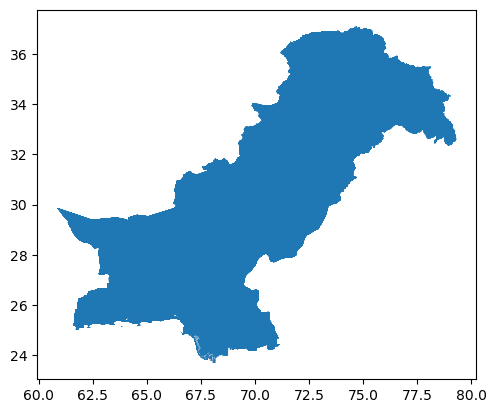

In [8]:
disasters_national_overlay[disasters_national_overlay.iso == "PAK"].plot()

<AxesSubplot:>

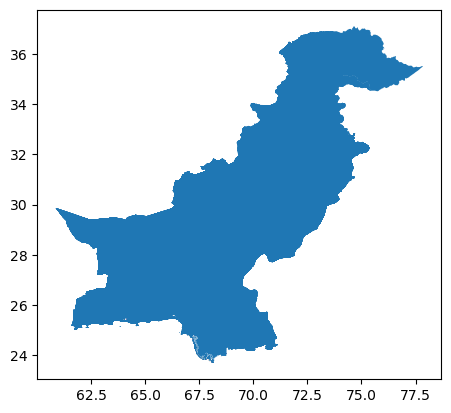

In [85]:
disasters_national_overlay[disasters_national_overlay.iso == "PAK"].plot()

In [89]:
(disasters_national_overlay[disasters_national_overlay["Dis No"].str.split("-",expand=True)[2] != disasters_national_overlay["iso"]])[['disaster_number_country','disaster_type']]

,disaster_number_country,disaster_type
1953,2000-0196-SCG,Flood
2034,2000-0383-SCG,Extreme temperature
2155,2000-0633-SCG,Wildfire
2258,2000-0868-SCG,Flood
2535,2001-0632-SPI,Flood
2686,2002-0171-SPI,Flood
2714,2002-0234-SCG,Earthquake
2767,2002-0367-SCG,Flood
2931,2002-0692-PAK,Earthquake
2943,2002-0721-PAK,Earthquake


In [90]:
#np.unique(disasters_national_overlay["iso"][(disasters_national_overlay["iso"] == "PAK") | (disasters_national_overlay["iso"] == "IND")],return_counts=True)

In [91]:
#idx_pak_events = ((disasters_national_overlay[disasters_national_overlay["Dis No"].str.split("-",expand=True)[2] != disasters_national_overlay["iso"]])[((disasters_national_overlay[disasters_national_overlay["Dis No"].str.split("-",expand=True)[2] != disasters_national_overlay["iso"]])["iso"] == "IND")]).index

In [81]:
idx_tur_events = ((disasters_national_overlay[disasters_national_overlay["Dis No"].str.split("-",expand=True)[2] != disasters_national_overlay["iso"]])[((disasters_national_overlay[disasters_national_overlay["Dis No"].str.split("-",expand=True)[2] != disasters_national_overlay["iso"]])["iso"] == "TLS")]).index

In [93]:
idx_tur_events

Int64Index([4624], dtype='int64')

In [94]:
#correct wrong entries from pakistan events

In [95]:
#disasters_national_overlay.loc[idx_pak_events,'iso'] = 'PAK'

In [96]:
#disasters_national_overlay.loc[idx_pak_events,'country'] = 'Pakistan'

In [97]:
#disasters_national_overlay.loc[idx_pak_events,'official_name'] = 'Islamic Republic of Pakistan'

In [98]:
#correct wrong entries from turkey event

In [82]:
disasters_national_overlay.loc[idx_tur_events,'iso'] = 'TUR'

In [83]:
disasters_national_overlay.loc[idx_tur_events,'country'] = 'Turkey'

In [84]:
disasters_national_overlay.loc[idx_tur_events,'official_name'] = 'Republic of Turkey'

<AxesSubplot:>

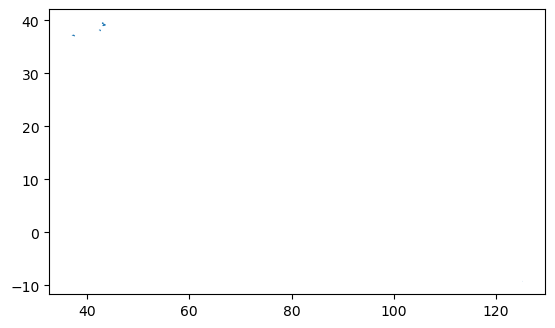

In [85]:
disasters_national_overlay.loc[idx_tur_events][["geometry"]].plot()

In [86]:
disasters_national_overlay.loc[idx_tur_events][["geometry"]].bounds

,minx,miny,maxx,maxy
4624,36.987195,-9.239008,125.199019,39.660507


In [87]:
from shapely.geometry import Polygon
polygon = Polygon([(36, 30), (36, 40), (45, 40), (45, 30), (36, 30)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=disasters_national_overlay.crs)

In [88]:
disasters_national_overlay.loc[idx_tur_events,"geometry"] = gpd.clip(disasters_national_overlay.loc[idx_tur_events][["geometry"]], poly_gdf)

<AxesSubplot:>

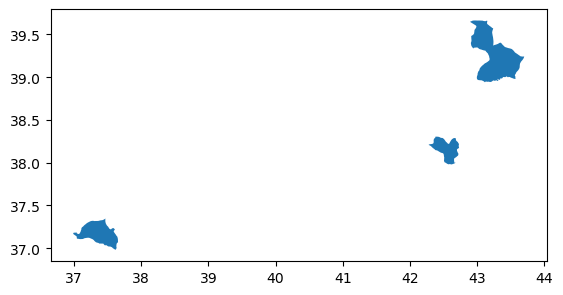

In [89]:
disasters_national_overlay.loc[idx_tur_events][["geometry"]].plot()

In [90]:
disasters_national_overlay.to_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay.gpkg", driver="GPKG")

In [2]:
disasters_national_overlay = gpd.read_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay.gpkg")

In [3]:
disasters_national_overlay["simplegeom"] = disasters_national_overlay.simplify(0.005)

In [9]:
import sys

In [14]:
sys.getsizeof(disasters_national_overlay.iloc[[1000]]["simplegeom"])

32

In [93]:
sys.getsizeof(disasters_national_overlay.iloc[[1000]])

2344

In [20]:
# Set geometry to be our new simlified geometry
disasters_national_overlay = disasters_national_overlay.set_geometry('simplegeom')

In [23]:
disasters_national_overlay = disasters_national_overlay.drop(columns="geometry")

In [28]:
disasters_national_overlay = disasters_national_overlay.rename_geometry("geometry")

In [99]:
sys.getsizeof(disasters_national_overlay.loc[[1000]])

2344

In [38]:
disasters_national_overlay.to_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay_simplified.gpkg", driver="GPKG")

In [2]:
disasters_national_overlay_simplified = gpd.read_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay_simplified.gpkg")

In [100]:
sys.getsizeof(disasters_national_overlay_simplified.loc[[1000]])

2336

In [96]:
sys.getsizeof(disasters_national_overlay.iloc[[1000]]["geometry"])

32

In [35]:
sys.getsizeof(disasters_national_overlay_simplified.iloc[[1000]]["geometry"])

32

<AxesSubplot:>

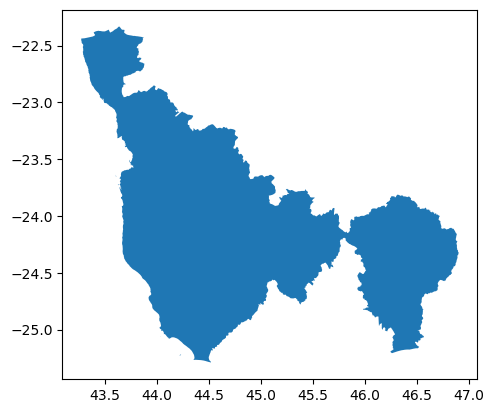

In [32]:
disasters_national_overlay.iloc[[9392]].plot()

<AxesSubplot:>

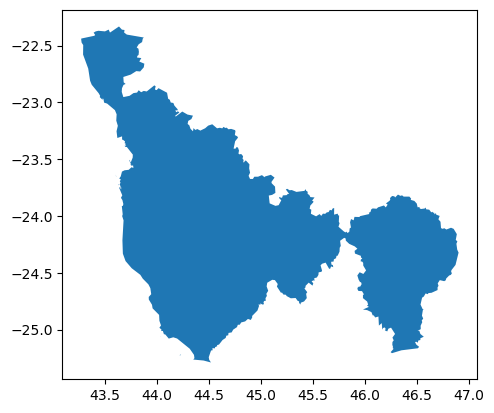

In [33]:
disasters_national_overlay_simplified.iloc[[9392]].plot()

In [ ]:
disasters_national_overlay_simplified.is_valid

In [101]:
#Simplify geometry again

In [3]:
disasters_national_overlay_simplified_copy = disasters_national_overlay_simplified.copy(deep=True)

In [30]:
disasters_national_overlay_simplified_copy["simplegeom"] = disasters_national_overlay_simplified_copy.simplify(0.01)

In [33]:
sys.getsizeof(disasters_national_overlay_simplified_copy.iloc[[7990]]["simplegeom"])

32

<AxesSubplot:>

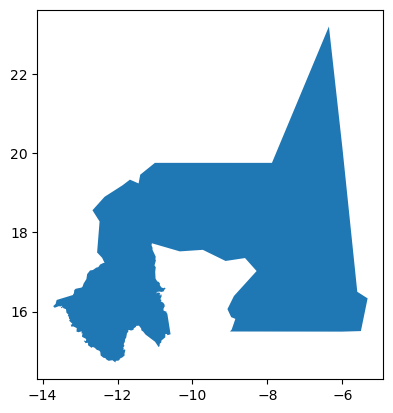

In [42]:
disasters_national_overlay_simplified_copy.iloc[[9393]]["simplegeom"].plot()

In [43]:
# Set geometry to be our new simlified geometry
disasters_national_overlay_simplified_copy = disasters_national_overlay_simplified_copy.set_geometry('simplegeom')

In [44]:
disasters_national_overlay_simplified_copy = disasters_national_overlay_simplified_copy.drop(columns="geometry")

In [45]:
disasters_national_overlay_simplified_copy = disasters_national_overlay_simplified_copy.rename_geometry("geometry")

In [51]:
disasters_national_overlay_simplified_copy.to_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay_simplified2.gpkg", driver="GPKG")

In [18]:
disasters_national_overlay_original = gpd.read_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay.gpkg")

#### Fix geometry validity 

In [2]:
disasters_national_overlay = gpd.read_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay_simplified2.gpkg")

In [37]:
def fix_invalid_geometry(geometry):
    if not geometry.is_valid:
        return geometry.buffer(0)
    else:
        return geometry

In [4]:
gdf_valid = disasters_national_overlay.copy(deep=True)

In [5]:
gdf_valid.geometry = gdf_valid.geometry.apply(
    lambda geom: fix_invalid_geometry(geom)
)

In [7]:
gdf_valid.is_valid

0       True
1       True
2       True
3       True
4       True
        ... 
9391    True
9392    True
9393    True
9394    True
9395    True
Length: 9396, dtype: bool

In [8]:
gdf_valid.to_file("/net/home/kteber/xaida_p1/data/gaul/disasters/disasters_national_overlay_simplified_valid.gpkg", driver="GPKG")

#### simplify admin 0 map 

In [48]:
countries = gpd.read_file('/net/home/kteber/xaida_dataset/data/gaul/gaul_admin0_clean.gpkg')

In [49]:
countries_copy = countries.copy(deep=True)

In [50]:
countries_copy["simplegeom"] = countries_copy.simplify(0.5)

In [51]:
# Set geometry to be our new simlified geometry
countries_copy = countries_copy.set_geometry('simplegeom')

In [52]:
countries_copy = countries_copy.drop(columns="geometry")

In [53]:
countries_copy = countries_copy.rename_geometry("geometry")

In [54]:
countries_copy.geometry = countries_copy.geometry.apply(
    lambda geom: fix_invalid_geometry(geom)
)

In [55]:
countries_copy.to_file("/net/home/kteber/xaida_p1/data/world_map_simplified3.gpkg", driver="GPKG")